# Meme Persuation Technique Classifier

# Loading and preprocessing the data

In [122]:
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
import json
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.utils.class_weight import compute_class_weight


In [123]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [124]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report


In [126]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [127]:
train_data = load_data("/kaggle/input/meme-persuasion-technique-text-data/train.json")
val_data = load_data("/kaggle/input/meme-persuasion-technique-text-data/validation.json")
dev_data = load_data("/kaggle/input/meme-persuasion-technique-text-data/dev_unlabeled.json")

In [128]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
dev_df = pd.DataFrame(dev_data)

In [129]:
dev_df=dev_df.dropna()
val_df = val_df.dropna()

In [130]:
train_df.head()

,id,text,labels,link
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...


In [131]:
dev_df.head()

,id,text
0,63292,This is why we're free\n\nThis is why we're sa...
1,70419,IF YOU SAY WE'RE IN THE MIDDLE OF A DEADLY PAN...
2,63673,AFTER A YEAR OF ZERO EVIDENCE OF RUSSIAN COLLU...
3,71297,MY WAY MY WAY
4,66340,Putin signed a decree to exclude Lyman from Ru...


In [132]:
labels = train_df["labels"]

mlb = MultiLabelBinarizer()
binary_labels_train = mlb.fit_transform(labels)
binary_labels_train_df = pd.DataFrame(binary_labels_train, columns=mlb.classes_)
train_df = pd.concat([train_df, binary_labels_train_df], axis=1)



In [133]:
labels = val_df["labels"]

mlb = MultiLabelBinarizer()
binary_labels_val = mlb.fit_transform(labels)
binary_labels_val_df = pd.DataFrame(binary_labels_val, columns=mlb.classes_)
val_df = pd.concat([val_df, binary_labels_val_df], axis=1)


In [134]:
train_df.columns

Index(['id', 'text', 'labels', 'link', 'Appeal to authority',
       'Appeal to fear/prejudice', 'Bandwagon',
       'Black-and-white Fallacy/Dictatorship', 'Causal Oversimplification',
       'Doubt', 'Exaggeration/Minimisation', 'Flag-waving',
       'Glittering generalities (Virtue)', 'Loaded Language',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Name calling/Labeling',
       'Obfuscation, Intentional vagueness, Confusion',
       'Presenting Irrelevant Data (Red Herring)', 'Reductio ad hitlerum',
       'Repetition', 'Slogans', 'Smears', 'Thought-terminating cliché',
       'Whataboutism'],
      dtype='object')

In [135]:
train_df.head()

,id,text,labels,link,Appeal to authority,Appeal to fear/prejudice,Bandwagon,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Doubt,...,Misrepresentation of Someone's Position (Straw Man),Name calling/Labeling,"Obfuscation, Intentional vagueness, Confusion",Presenting Irrelevant Data (Red Herring),Reductio ad hitlerum,Repetition,Slogans,Smears,Thought-terminating cliché,Whataboutism
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [136]:
train_df.shape

(7000, 24)

In [137]:
binary_labels_train.shape

(7000, 20)

In [138]:
print('average sentence length: ', train_df.text.str.split().str.len().mean())
print('stdev sentence length: ', train_df.text.str.split().str.len().std())

average sentence length:  17.928428571428572
stdev sentence length:  16.846987707468237


# Model Training

In [139]:
model_name = 'owaiskha9654/Multi-Label-Classification-of-PubMed-Articles'
max_length = 100

config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=config)
transformer_model = TFBertModel.from_pretrained(model_name, config=config)

bert = transformer_model.layers[0]
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}


bert_output = bert(inputs)[1]


labels = Dense(units=20, name='labels')(bert_output)

outputs = {'labels': labels}
model = Model(inputs=inputs, outputs=outputs, name='Multi-Label-Classification-of-PubMed-Articles')
model.summary()
optimizer = Adam(learning_rate=0.00001, weight_decay=0.01)
loss = {'labels': CategoricalCrossentropy(from_logits = True)}
metric = {'labels': CategoricalAccuracy('accuracy')}

model.compile(optimizer=optimizer, loss=loss, metrics=metric)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "Multi-Label-Classification-of-PubMed-Articles"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['attention_mask[0][0]',      
                             ngAndCrossAttentions(last_   72         'input_ids[0][0]']           
                             hidden_state=(None, 100, 

In [140]:
print(transformer_model.layers)

In [141]:


x_train = tokenizer(
    text=train_df['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_val =tokenizer(
    text=val_df['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

history = model.fit(
    x={'input_ids': x_train['input_ids'],'attention_mask': x_train['attention_mask']},
    y=binary_labels_train,
    validation_data=({'input_ids': x_val['input_ids'],'attention_mask': x_val['attention_mask']}, binary_labels_val),
    batch_size=16,
    epochs=10)

Epoch 1/10
438/438 [==============================] - 185s 254ms/step - loss: 4.3936 - accuracy: 0.1417 - val_loss: 4.5951 - val_accuracy: 0.1520
Epoch 2/10
438/438 [==============================] - 99s 225ms/step - loss: 4.3459 - accuracy: 0.2064 - val_loss: 4.7668 - val_accuracy: 0.1840
Epoch 3/10
438/438 [==============================] - 98s 223ms/step - loss: 4.3309 - accuracy: 0.2439 - val_loss: 4.6874 - val_accuracy: 0.2220
Epoch 4/10
438/438 [==============================] - 97s 222ms/step - loss: 4.3011 - accuracy: 0.2549 - val_loss: 4.6443 - val_accuracy: 0.2240
Epoch 5/10
438/438 [==============================] - 98s 223ms/step - loss: 4.2675 - accuracy: 0.2689 - val_loss: 4.7585 - val_accuracy: 0.2300
Epoch 6/10
438/438 [==============================] - 97s 222ms/step - loss: 4.2737 - accuracy: 0.2701 - val_loss: 4.6683 - val_accuracy: 0.2360
Epoch 7/10
438/438 [==============================] - 97s 221ms/step - loss: 4.2250 - accuracy: 0.2711 - val_loss: 4.6572 - val_a

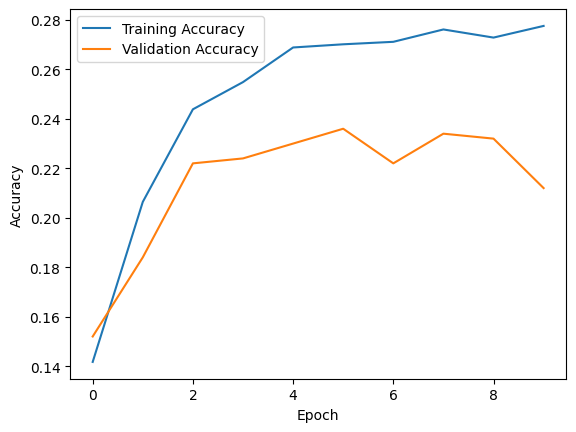

In [142]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [143]:
y_val_pred = model.predict({'input_ids': x_val['input_ids'],'attention_mask': x_val['attention_mask']})
print(y_val_pred['labels'].shape)
positive_class_probs = y_val_pred['labels'][:, :]

y_val_pred_classes = np.where(positive_class_probs > 0.5, 1, 0)

y_val_true_classes = binary_labels_val

print("Classification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes))


16/16 [==============================] - 5s 132ms/step
(500, 20)
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.97      0.31        63
           1       0.07      0.89      0.13        27
           2       0.02      0.86      0.04         7
           3       0.14      0.85      0.24        53
           4       0.05      0.86      0.10        21
           5       0.04      0.58      0.08        24
           6       0.06      0.78      0.12        27
           7       0.11      0.86      0.19        42
           8       0.09      0.86      0.17        36
           9       0.34      0.84      0.49       135
          10       0.01      0.75      0.02         4
          11       0.31      0.87      0.45       116
          12       0.00      0.50      0.01         2
          13       0.01      0.75      0.02         4
          14       0.01      1.00      0.02         4
          15       0.06      0.87      0.11    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
